\begin{equation}
\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} + \nu \frac{\partial^2 u}{\partial y^2}
\end{equation}

In [1]:
#Librería para plotear en 3D
from mpl_toolkits.mplot3d import Axes3D

#Incluímos las librerías que vamos a usar
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time, sys

In [7]:
class domain:
    #El constructor se encarga de hacer el preprocesamiento
    def __init__(self, Lx, Ly, T, v, dx, dy, dt):       
        self.Nx = int(Lx/dx)                   #Número de puntos desde 0 hasta Nx
        self.x = np.linspace(0, Lx, self.Nx+1)   #Creo un vector que va desde el 0 hasta Lx con Nx+1 divisiones
        self.dx = self.x[1]-self.x[0]          #Chequeo del dx, para que coincida
        
        self.Ny = int(Ly/dy)                   #Número de puntos desde 0 hasta Ny
        self.y = np.linspace(0, Ly, self.Ny+1)   #Creo un vector que va desde el 0 hasta Ly con Ny+1 divisiones
        self.dy = self.y[1]-self.y[0]          #Chequeo del dy, para que coincida

        self.Nt = int(T/dt)                   #Número de puntos desde 0 hasta Nt
        self.t = np.linspace(0, T, self.Nt+1)   #Creo un vector que va desde el 0 hasta T con Nt+1 divisiones
        self.dt = self.t[1]-self.t[0]         #Chequeo del dt, para que coincida

        self.alfa = v*self.dt/(self.dx)**2          #Calculo el número de Courant
        self.beta = v*self.dt/(self.dy)**2          #Calculo el número de Courant
        
        #Creamos dos matrices: una representa el tiempo presente y la otra el tiempo futuro
        self.u_2 = np.zeros((self.Nx+1, self.Ny+1))
        self.u_1 = np.zeros((self.Nx+1, self.Ny+1))

    
    #En este método incluimos la condición inicial para t=0 en todo el dominio x,y
    def initialCond(self):
        #Añadimos la condición inicial en la posicón del presente
        self.u_1[int(0.7/self.dx):int(1/self.dx), int(0.7/self.dy):int(1/self.dy)] = 1.5
        self.u_2[int(0.7/self.dx):int(1/self.dx), int(0.7/self.dy):int(1/self.dy)] = 1.5
        
        #Graficamos la condición inicial
        fig = plt.figure(figsize=(11, 7), dpi=100)       #Creo una ventana para graficar llamada fig
        ax = plt.axes(projection='3d')                   #Para crear ejes en las tres dimensiones
        self.X, self.Y = np.meshgrid(self.x, self.y)     #Creo un enmallado usando los vectores unidimensionales
        ax.plot_surface(self.X, self.Y, self.u_1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
        ax.view_init(20, 290)
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')
        ax.set_zlabel('Velocidad[m/s]')
        ax.set_title('Condiciones iniciales t=%.2f' % self.t[0])

    
    def solver_loop(self):
        self.row, self.col = self.u_1.shape

        for n in range(1, self.Nt):
            #Definimos los valores de la frontera
            self.u_2[:, 0] = 0   #Para todas las filas, columna 0
            self.u_2[:, -1] = 0  #Para todas las filas, última columna
            self.u_2[0, :] = 0   #Para todas las columnas, fila 0
            self.u_2[-1, :] = 0  #Para todas las columnas, última fila

            for j in range(1, self.row-1):
                for i in range(1, self.col-1):
                    self.u_2[j, i] = self.u_1[j, i] + self.alfa*(self.u_1[j, i+1] - 2*self.u_1[j, i] + self.u_1[j, i-1])  + \
                                     self.beta*(self.u_1[j+1, i] - 2*self.u_1[j, i] + self.u_1[j-1, i])
                    
            self.u_1 = self.u_2.copy()

    def solver_vector(self):
        self.row, self.col = self.u_1.shape

        for n in range(1, self.Nt):
            #Definimos los valores de la frontera
            self.u_2[:, 0] = 0   #Para todas las filas, columna 0
            self.u_2[:, -1] = 0  #Para todas las filas, última columna
            self.u_2[0, :] = 0   #Para todas las columnas, fila 0
            self.u_2[-1, :] = 0  #Para todas las columnas, última fila

            self.u_2[1:-1, 1:-1] = self.u_1[1:-1, 1:-1] + self.alfa*(self.u_1[1:-1, 2:] - 2*self.u_1[1:-1, 1:-1] + self.u_1[1:-1, :-2])  + \
                                     self.beta*(self.u_1[2:, 1:-1] - 2*self.u_1[1:-1, 1:-1] + self.u_1[:-2, 1:-1])
            
            #Actualizamos
            self.u_1 = self.u_2.copy()
                    
        
                    

    def plotter_3D(self):
        fig = plt.figure(figsize=(11, 7), dpi=100)       #Creo una ventana para graficar llamada fig
        ax = plt.axes(projection='3d')                   #Para crear ejes en las tres dimensiones
        ax.plot_surface(self.X, self.Y, self.u_2[:], rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none')
        ax.view_init(20, 290)
        ax.set_xlabel('x[m]')
        ax.set_ylabel('y[m]')
        ax.set_zlabel('Velocidad[m/s]')
        ax.set_title('Simulación en t=%.2f' % self.t[-1])
        ax.set_zlim(0, 1.8)
        
    def __str__(self):
        return 'Información de la simulación:\nNodos en x: {}\nNodos en y: {}\nNodos en t: {}\nAlfa: {:.2f}\nBeta: {:.2f}\n'.format(self.Nx+1, self.Ny+1, self.Nt+1, self.alfa, self.beta)

In [8]:
#Definimos las propiedades y condiciones de simulación
Lx = 2
Ly = 2
T = 0.15
v = 0.3
dx = 0.05
dy = 0.05
dt = 0.000225

#Creo el objeto string
surface = domain(Lx, Ly, T, v, dx, dy, dt)
print(surface)

Información de la simulación:
Nodos en x: 41
Nodos en y: 41
Nodos en t: 667
Alfa: 0.03
Beta: 0.03



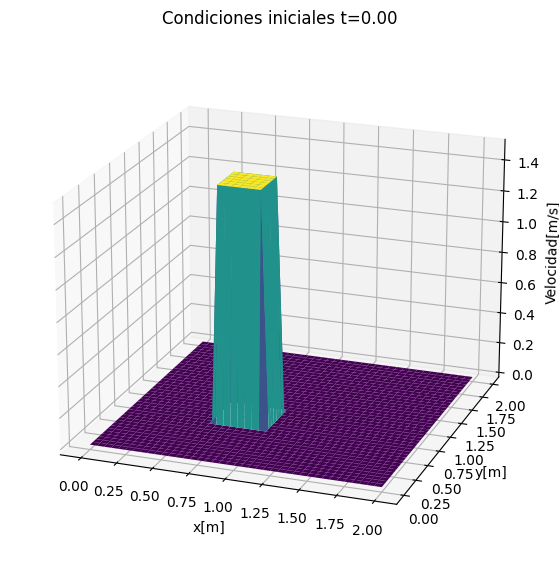

In [9]:
#Grafico las condiciones iniciales
surface.initialCond()

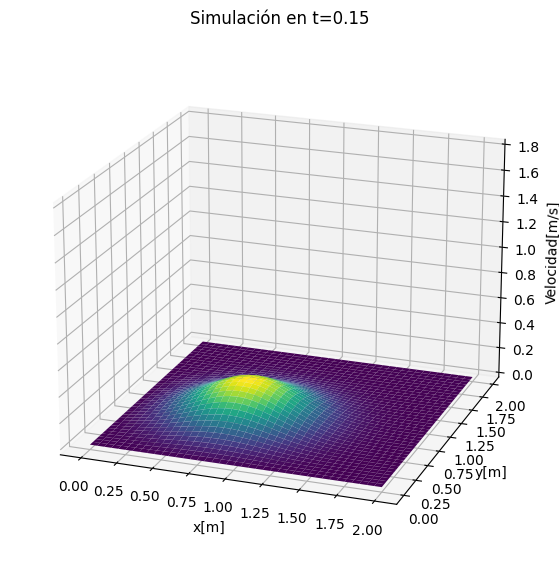

In [5]:
surface.solver_vector()
surface.plotter_3D()

Información de la simulación:
Nodos en x: 41
Nodos en y: 41
Nodos en t: 3556
Alfa: 0.03
Beta: 0.03



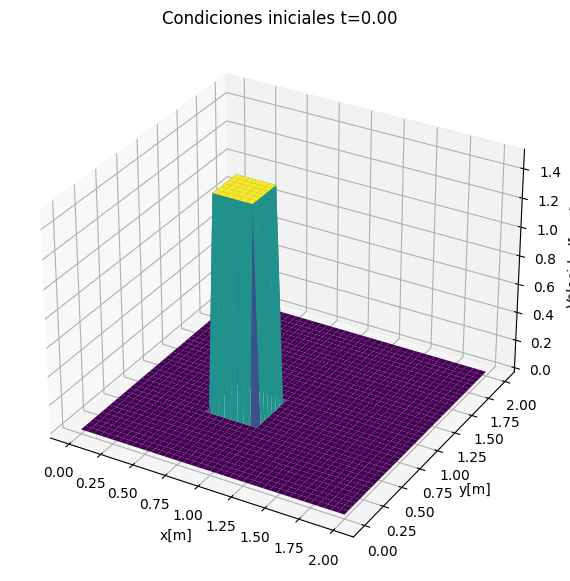

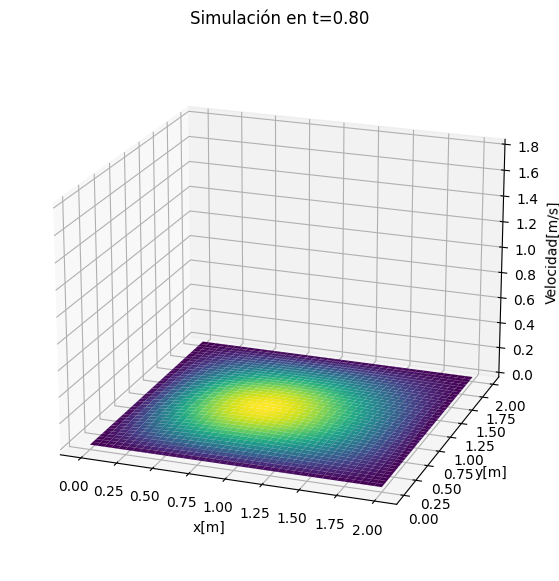

In [6]:
#Definimos las propiedades y condiciones de simulación
Lx = 2
Ly = 2
T = 0.8
v = 0.3
dx = 0.05
dy = 0.05
dt = 0.000225

#Creo el objeto string
surface01 = domain(Lx, Ly, T, v, dx, dy, dt)
print(surface01)

#Grafico las condiciones iniciales
surface01.initialCond()

surface01.solver_vector()
surface01.plotter_3D()